<script type="text/x-mathjax-config">

MathJax.Hub.Config({

  tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}

});

</script>

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/latest.js?config=TeX-MML-AM_CHTML' async></script>

## Project7 인공신경망 분류기

### 1. 개요

이번 프로젝트에서는 인공신경망 분류기를 구현한다. 

데이터의 분석과 시각화를 위해서 미리 정의해둔 플로팅 함수들을 사용한다. 해당 함수들은 projectfiles.analyzer.graphics에 정의되어있다.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from projectfiles.analyzer.graphics import plot_decision_regions, plot_data
from projectfiles.analyzer.statistics import classification_accuracy

### 2. 인공신경망의 기본 개념과 퍼셉트론

ANN(Artificial Neural Network, 인공신경망)은 실제 인체 내부의 신경(neuron)의 작동방식을 모방하여 학습하는 인공지능 모델이다. ANN을 이용하여 분류기를 생성할 경우 이차 이상의 결정 경계를 생성할 수 있으며, 비선형적인 데이터 특성을 모델이 직접 추출하여 복잡한 형태의 데이터셋을 학습하는데 용이하다. 또한 이미지 처리와 같은 분야에서 주로 사용되는 CNN(Convolution Neural Newtork, 합성곱신경망)의 기본이 되는 인공지능 모델이기도 하다.

실제 인체의 신경망과 마찬가지로 인공신경망에도 수많은 인공 뉴런들이 존재한다. 이때 인공뉴런은 다음과 같이 표현된다.

<img src="images/7_ANN_Classifier/Figure1_Artificial_Neuron.jpg" width="400px">

뉴런은 입력신호 $x$와 출력신호 $y$를 갖는다. 지금은 입력신호와 출력신호가 모두 하나의 값(실수 형태)이라 가정하자. 그렇다면 하나의 인공뉴런은 사실상 입출력이 모두 실수인 하나의 함수개체(function block)로 볼 수 있다. 이때 하나의 인공뉴런에 대한 함수식은 위 그림에서 확인하듯 $y=h(wx+b)$이며 각 파라미터의 의미는 다음과 같다:

1. $w$: 가중치 (weight)
2. $b$: 편향 (bias)
3. $h$: 비선형 활성화 함수 (nonlinear activation function)

위의 파라미터들은 이미 로지스틱회귀와 SVM을 구현하면서 한번은 확인한 것들이니 자세한 설명은 생략한다. 이전과 다른점은 가중치벡터가 하나의 값으로 변환되었다는 점이다. 하지만 이는 입력이 하나의 값이라는 것을 생각하면 쉽게 납득 가능하다. 위의 식을 이용하여 인공뉴런의 출력을 정의하면 다음과 같다:

<blockquote>인공뉴런의 출력은 입력값을 가중치 $w$와 편향 $b$를 이용하여 선형변환한 후 이를 활성화하여 생성한다</blockquote>

인공신경망은 위에서 소개한 단일 인공 뉴런을 연결한 것을 말한다. 인공신경망은 다음과 같이 나타낼 수 있다.

<img src="images/7_ANN_Classifier/Figure2_Basic_Network.jpg" width="400px">

위의 인공신경망에서는 여러 뉴런들이 연결되어있다. 그런데 이것을 바로 구현하는 것은 굉장히 까다롭고 연산량이 많아 속도도 느리다. (각 뉴런의 입력과 출력이 여러 갈래로 나뉘기 때문에 계산량이 많음)  따라서 위의 그림에서 몇 개의 인공뉴런들을 통합하여 실제 인공신경망의 최소단위인 퍼셉트론(perceptron) 모델을 정의하고자 한다.

위의 그림을 잘 살펴보면 하나의 인공뉴런이 다수의 입력을 받고 있다는 것을 확인할 수 있다. 따라서 인공 뉴런의 구조를 다음과 같이 수정한다. (얇은 선은 실수를 의미하고 굵은 선은 벡터를 의미한다)

<img src="images/7_ANN_Classifier/Figure3_Artificial_Neuron2.jpg" width="600px">

위의 그림을 잘 살펴보면 뉴런의 입력이 길이가 $n$인 벡터임을 알 수 있다. 따라서 앞서 정의한 가중치 $w$는 길이가 $n$인 벡터의 형태가 된다.

이렇듯 하나의 입력벡터를 통해 출력값을 정의하는 인공뉴런 구조를 퍼셉트론이라 부른다. 퍼셉트론은 인공신경망의 최소단위로 실제 인체 내부의 뉴런이 동작하는 방식을 그대로 모방한다. 퍼셉트론은 입력 벡터를 적절히 선형적으로 변환하여 $a$를 생성한 뒤, 이 값을 함수 $h$에 의해 활성화시켜 출력값 $y$를 생성한다. 그리고 생성된 출력값 $y$는 다른 뉴런의 입력으로 전달되어 네트워크의 최종 출력을 생성하는데 사용된다.

이처럼 퍼셉트론을 유기적으로 연결하면 위의 인공신경망을 다음과 같이 변환할 수 있다. (앏은 선을 실수의 전파를 의미하고, 굵은 선은 벡터의 전파를 의미한다)

<img src="images/7_ANN_Classifier/Figure4_1_Basic_Network2.jpg" width="600px">

추가적으로 활성화 함수가 로지스틱 시그모이드 함수인 퍼셉트론 모델은 앞선 프로젝트에서 구현한 로지스틱회귀 모델과 완벽하게 동일하다. 따라서 퍼셉트론 모델의 학습과 예측과정(SGD를 이용하는 방법)은 로지스틱회귀 모델과 완벽하게 동일하며 위의 그림과 같이 로지스틱회귀 모델을 물리적으로 여러 개 연결하는 방식으로 ANN을 구성할 수도 있다. 다만 이번 프로젝트에서는 이러한 방식으로 ANN을 구현하지 않으며, 이에 대한 자세한 설명은 생략한다.

### 3. 인공신경망의 계층화

위에서 소개한 인공신경망 그림을 자세히 살펴보면 입력벡터가 같은 퍼셉트론들이 있다는 것을 알 수 있다. 구현의 용이성을 위하여 이러한 퍼셉트론들을 아래 그림처럼 하나의 계층(layer)으로 묶고자 한다.

<img src="images/7_ANN_Classifier/Figure4_Basic_Network2.jpg" width="600px">

위의 그림에서 각 사각형들은 같은 입력벡터를 갖는 퍼셉트론들을 묶은 것이다. (물론 input과 output에 해당하는 것들은 퍼셉트론은 아니지만 그래도 일반성을 위해 위와 같이 표시한다) 이들을 하나의 계층으로 통합하기 위해 각 퍼셉트론들의 출력을 하나의 벡터로 통합하고자 한다. 쉽게 말해 퍼셉트론들의 출력값 $y_1, y_2, \cdots, y_m$을 원소로 하는 벡터 $y$를 다음과 같이 정의한다:

$$y = (y_1, y_2, \cdots, y_m)$$

그렇다면 하나의 계층을 다음과 같이 나타낼 수 있다. (얇은 선은 실수를 의미하고 굵은 선은 벡터를 의미한다)

<img src="images/7_ANN_Classifier/Figure5_Network_Layer.jpg" width="600px">

위의 그림에서 $w_1, w_2, \cdots, w_m$은 모두 길이가 $n$인 벡터들이므로 이들을 열벡터로 하는 $n \times m$크기의 가중치 행렬 $w$를 다음과 같이 정의한다:

$$ w = (w_1, w_2, \cdots, w_m) $$

마찬가지로 편향값 $b_1, b_2, \cdots, b_m$과 중간 출력값 $a_1, a_2, \cdots, a_m$ 또한 하나로 합쳐 길이가 $m$인 벡터를 생성한다.

$$ b = (b_1, b_2, \cdots, b_m) $$

$$ a = (a_1, a_2, \cdots, a_m) $$

그렇다면 최종적으로 위에서 정의한 식들을 이용하여 하나의 계층을 다음과 같이 재구성할 수 있다:

<img src="images/7_ANN_Classifier/Figure6_Network_Layer2.jpg" width="600px">

이제는 하나의 네트워크를 계층간 벡터의 전파로 표현할 수 있게 되었다. 이렇게 네트워크를 계층화하는 주된 목적은 산발적인 여러 연산들을 하나의 행렬 연산으로 병렬화시켜 그 속도를 빠르게 하기 위함이다. 따라서 제일 처음에 소개했던 단일 인공 신경 모델을 물리적으로 연결하여 인공신경망을 구현한 것과 네트워크를 계층화시켜 구현한 것의 결과가 같다 하더라도, 그 속도는 계층화시킨 것이 훨씬 더 빠르다.

<img src="images/7_ANN_Classifier/Figure7_Basic_Network3.jpg" width="600px">

위 그림에서 입력층과 출력층은 각각 input과 output이라는 이름으로 표시되어있다. 이 두 계층은 특별한 연산을 수행하지 않는 입력단자와 출력단자의 역할만을 수행한다. 실제로 퍼셉트론들이 위치하는 계층은 입력층과 출력층 사이에 위치한 은닉층(hidden layer)이다. 이 계층의 경우 사용자에 의해 접근되지 않으며 실제로 하이퍼 파라미터들을 갱신하며 학습을 수행한다.

일반적으로 2개의 은닉층을 갖는 인공신경망 모델을 ANN모델이라 부른다. 은닉층이 3개 이상인 모델들은 따로 DNN(Deep Neural Network)모델이라고 한다. 이번 프로젝트에서는 2개의 은닉층을 갖는 ANN 이진 분류기를 설계하고자 한다. 

### 4. 역전파 이론

인공신경망 이론의 주된 근간은 바로 지금부터 설명하고자 하는 역전파(backward propagation, back-propagation)이론에 있다. 역전파 이론은 신호를 역으로 전파함으로써 전체적인 계층간 변화율(미분계수)를 구할 수 있다는 이론이다. 이 이론은 일반적으로 대학 미적분학에서 배우는 연쇄법칙(chain rule)에 의해 증명된다. 이를 이용하면 기울기 벡터(gradient)를 이용하여 가중치를 갱신하는 다양한 최적화 방법(예를 들어 SGD등이 있다)들을 이용할 수 있다.

네트워크의 순전파(forward propagation)은 입력 $x$를 이용하여 최종 출력 $y$를 재귀적으로 구하는 과정 전체를 말한다. 반대로 역전파는 출력에 이전 계층의 기울기를 집어넣고 이를 역방향으로 전파하여 최종적인 기울기를 구하는 과정을 의미한다.

예를 들어 다음과 같은 네트워크가 있다고 가정해보자.

<img src="images/7_ANN_Classifier/Figure8_forward_propa.jpg" width="330px">

이때 위의 네트워크에 대한 역전파는 다음과 같이 나타낼 수 있다.

<img src="images/7_ANN_Classifier/Figure9_backward_propa.jpg" width="400px">

위의 그림에서 확인할 수 있듯, 역전파 과정에서 각 계층들은 입력에 대한 최종 출력의 기울기 벡터를 계산하여 역전파한다. 쉽게 말해 역전파 과정에서 각 계층은 최종 출력의 미분을 수행한다. 하지만 위와 같이 역전파를 구현하는 것은 쉬운 일이 아니다. 위의 그림에서도 확인할 수 있듯 하나의 계층은 다른 계층의 내부 구조를 알지 못하므로 단순한 계산으로 미분 계수를 구하는 것은 불가능하다.

여기서 연쇄법칙을 사용한다. 연쇄법칙에 따르면 첫번째 계층의 최종 출력에 대한 기울기는 다음과 같이 계산이 가능하다.

$$ a = f(x) \ \ , \ \ \ y = g(a) = g(f(x)) $$

$$ \frac{\partial a}{\partial x} = f'(x) $$

$$ \frac{\partial y}{\partial a} = g'(a) = g'(f(x)) $$

$$\frac{\partial y}{\partial x}=\frac{\partial y}{\partial a}\frac{\partial a}{\partial x} = f'(x)g'(f(x))$$

이때 $\partial y / \partial a$는 이전 계층에서 전달되므로 실질적으로 계산해야 할 것은 $\partial a / \partial x$밖에 없다. 이때 $\partial a / \partial x = f'(x)$는 계층 내부에서 해석적으로 계산될 수 있으므로, 결국 각 계층에서의 입력에 대한 최종 출력의 기울기 벡터를 구할 수 있다.

이처럼 계층 내부에서 각 계층의 미분을 계산할 수 있도록 함으로써 각 계층에 대한 미분을 계산하는 역전파 시퀀스를 구현할 수 있다. 또한 역전파를 통해 각 계층의 입력에 대한 최종 출력의 기울기를 계산함으로써 SGD와 같은 학습 알고리즘을 사용할 수 있다.

### 5. Affine 계층

이제부터는 각 계층들을 구현한다. 앞서 말했듯 각 계층들은 순전파와 역전파를 위한 기능들을 반드시 포함해야 한다. 이를 이용해 재귀적으로 네트워크의 최종 출력을 계산하고 최종 출력에 대한 기울기를 구한다. 그리고 최종적으로는 기울기를 활용하여 하이퍼 파라미터를 갱신하고 학습을 수행하도록 한다.

위에서 정의한 단일 계층의 구성요소는 크게 두 가지이다. 하나는 중간 출력 $a$를 생성하는 선형변환기이고, 다른 하나는 활성화 함수 블럭이다. 이 중 선형변환기를 일반적으로 아핀(affine) 계층이라 한다. (선형변환이 아핀 변환의 한 종류이기 때문으로 추측한다)

아핀 계층의 순전파 식은 다음과 같다:

$$ y = xw + b $$

만약 $x$의 크기가 $n$이고 $y$의 크기가 $m$이라면 $w$는 크기가 $n \times m$인 행렬이고 $b$는 크기가 $m$인 벡터이다. 

위의 식을 이용하면 역전파시 필요한 기울기 또한 계산할 수 있다. 최종적인 출력값이 $l$일 때 기울기(gradient)를 구하면 다음과 같이 나타난다 (이때 $\partial l / \partial y$는 이전 계층으로부터 전달받은 기울기 벡터이다):

$$ \frac{\partial l}{\partial x} = \frac{\partial l}{\partial y} \cdot w^T $$

$$ \frac{\partial l}{\partial w} = x^T \cdot \frac{\partial l}{\partial y} $$

$$ \frac{\partial l}{\partial b} = \frac{\partial l}{\partial y} $$

이때 $\partial l / \partial x$는 다음 계층으로 전파되고, $\partial l / \partial w$와 $\partial l / \partial b$는 하이퍼 파라미터 $w$와 $b$를 갱신하는데 사용된다. 위 공식들에 대한 자세한 유도는 생략한다. 행렬의 각 원소들에 대해 미분을 진행해보면 위 공식들을 유도할 수 있다.

위 공식들을 이용하여 최종적으로 아핀 계층을 구현한다. 아래 코드에서 Affine이 이에 해당한다. 이 클래스는 projectfiles.common.layers에 구현되어있으니 참고할 것.

In [2]:
class Affine(object):
    def __init__(self, w, b):
        self.w = w  # 가중치 행렬
        self.b = b  # 편향 벡터

        self.x = None   # 순전파시 이용되었던 입력 벡터
        self.dw = None  # 가중치 행렬에 대한 기울기
        self.db = None  # 편향 벡터에 대한 기울기

    def forward(self, x):
        self.x = x

        return np.dot(self.x, self.w) + self.b

    def backward(self, dout):
        # dout은 현재 출력에 대한 최종 출력의 미분 -> 이전 계층으로부터 전파됨
        self.dw = np.dot(self.x.T, dout)  # 가중치 행렬에 대한 기울기 계산
        self.db = np.sum(dout, axis=0)    # 편향 벡터에 대한 기울기 계산

        return np.dot(dout, self.w.T)  # 현재 입력에 대한 기울기를 계산한 후 다음 계층으로 역전파

추가적으로 위의 두 하이퍼 파라미터를 초기화 하는 두 모델을 구현하고자 한다. 하나는 정규화된 임의 행렬을 생성하고, 다른 하나는 0으로 초기화된 행렬을 생성한다. 이 모델들은 projectfiles.common.initialziers에 구현되어있다.

In [3]:
# 정해진 평균과 표준편차로 정규화된 임의의 행렬을 생성하는 모델
class RandomNormal(object):
    def __init__(self, mean, stddev, random_state=None):
        self.mean = mean
        self.stddev = stddev
        self.random_state = random_state
        self.rgen = np.random.RandomState(seed=random_state)

    def __call__(self, shape):
        return self.rgen.normal(loc=self.mean, scale=self.stddev, size=shape)

    
# 0으로 초기화된 행렬을 생성하는 모델
class Zeros(object):
    def __init__(self):
        return

    def __call__(self, shape):
        return np.zeros(shape=shape)

    
normal_initializer = RandomNormal(mean=0., stddev=0.01, random_state=1)
zeros_initializer = Zeros()

print(normal_initializer(shape=(2, 3)))
print(zeros_initializer(shape=(2, 3)))

[[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
[[0. 0. 0.]
 [0. 0. 0.]]


이렇게 두 가지 초기화 모델을 구현한 이유는 가중치 행렬과 편향 벡터의 초기화 방식이 다르기 때문이다. 위의 아핀 계층의 역전파 공식에서 가중치 행렬은 기울기를 계산하는데 사용되지만, 편향 벡터는 사용되지 않는다. 따라서 가중치 행렬은 0으로 초기화되어서는 안된다. (기울기가 소실되어 제대로된 역전파가 일어나지 않을 수 있다) 따라서 가중치 행렬은 일반적으로 0으로 초기화하지 않는다.

### 6. Activation 계층

이제부터는 활성화 계층을 구현하고자 한다. ANN을 구성할 때 사용되는 활성화 함수는 크게 3가지가 있다.

1. 시그모이드 함수 (sigmoid function)
    - 뉴런의 기본적인 동작 원리인 '역치 이상의 신호만을 필터링한다'에 입각하여 만들어진 함수
    - 크기가 2인 벡터에 한해 소프트맥스 함수와 동일한 결과를 리턴한다


2. 렐루 함수 (ReLU function)
    - 시그모이드 함수보다 좀 더 뉴런의 동작 원리에 가까운 함수
    - 역치(0) 이상의 신호들을 필터링한다
    - 최근에 활성화 함수로 많이 사용되고있다 
    

3. 소프트맥스 함수 (softmax function)
    - 각 벡터를 확률밀도의 형태로 스케일링(scaling)하는 함수
    - 입력 벡터에 대해 총 합이 1인 확률 밀도를 리턴한다
    - 네트워크의 말단을 활성화하는데 주로 사용된다

그리고 각 함수들의 순전파는 다음과 같이 수식으로 표현된다:

$$sigmoid(x) = \frac{1}{1+e^{-x}} \ \ \cdots \ \ \text{Sigmoid function}$$

$$relu(x)=\left\{\begin{matrix}
x & \text{if } x \ge 0\\ 
0 & \text{otherwise}
\end{matrix}\right. \ \ \cdots \ \ \text{ReLU function}$$

$$softmax(x) = \frac{e^{x}}{\sum_{i}e^{x_i}} \ \ \cdots \ \ \text{Softmax function}$$

아래 코드는 위의 수식들을 통해 세가지 함수들을 파이썬 코드로 구현한 것이다. 아래에 구현된 함수들은 projectfiles.common.activation_functions에 구현되어있다.

In [4]:
def sigmoid(x, C=250):
    return 1. / (1. + np.exp(-np.clip(x, -C, C)))


def relu(x):
    return np.maximum(0, x)


def softmax(x, C=250):
    if x.ndim == 2:
        x = x.T
        y = np.exp(-np.clip(x, -C, C)) / np.sum(np.exp(-np.clip(x, -C, C)), axis=0)
        return y.T

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

그리고 위 함수들의 역전파를 구하기 위해 각 함수들의 미분형을 유도하면 다음과 같다:

1. 시그모이드 함수 미분

$$y = \frac{1}{1+e^{-x}}$$

$$ \frac{\partial y}{\partial x} = -(\frac{1}{1+e^{-x}})^2\times (-e^{-x})=\frac{1}{1+e^{-x}} \frac{e^{-x}}{1+e^{-x}}=y(1-y)$$

2. 렐루 함수 미분

$$y=\left\{\begin{matrix}
x & \text{if } x \ge 0\\ 
0 & \text{otherwise}
\end{matrix}\right.$$

$$\frac{\partial y}{\partial x}=\left\{\begin{matrix}
1 & \text{if } x \ge 0\\ 
0 & \text{otherwise}
\end{matrix}\right.$$

3. 소프트맥스 함수

$$y = \frac{e^{x}}{\sum_{i}e^{x_i}}$$

$$\frac{\partial y}{\partial x} = \frac{e^{x}\sum_{i}e^{x_i}-(e^{x})^2}{(\sum_{i}e^{x_i})^2}=\frac{e^{x}}{\sum_{i}e^{x_i}} \frac{\sum_{i}e^{x_i}-e^{x}}{\sum_{i}e^{x_i}}=y(1-y)$$

소프트맥스와 시그모이드 함수의 미분형이 동일한 것은 우연이 아니다. 이는 소프트맥스 함수가 시그모이드 함수로부터 유도된 함수이기 때문이다. 이에 대한 자세한 설명은 생략한다.

이제는 이 세가지 함수들을 이용한 활성화 계층(activation layer)을 구현한다. 아래 구현된 Sigmoid, Relu 그리고 Softmax는 projectfiles.common.layers에 구현되어있다. 

In [5]:
class Sigmoid():
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = sigmoid(x)

        return self.out

    def backward(self, dout):
        return dout * (1. - self.out) * self.out


class Relu():
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = relu(x)

        return self.out

    def backward(self, dout):
        dx = dout.copy()
        dx[self.out == 0] = 0

        return dx


class Softmax():
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = softmax(x)

        return self.out

    def backward(self, dout):
        return dout * self.out * (1. - self.out)

다음으로 넘어가기 전 손실 계층에 대한 설명을 추가하고자 한다. 앞서 우리는 로지스틱회귀를 구현하면서 시그모이드 함수를 손실 함수로 사용하였다. 이때 시그모이드 함수를 사용한 주 이유는 션형 변환된 값을 확률 변수로서 활성화시키기 위함이었다. 그렇지만 출력의 크기가 일반적으로 벡터형태로 나타나는 ANN의 경우 시그모이드 함수를 통해 확률변수로 변환할 수 없다. 따라서 ANN에서는 네트워크의 말단에서 출력을 확률변수로 변환하기 위해 새롭게 정의된 함수인 소프트맥스를 사용한다. 소프트맥스 함수는 시그모이드 함수로부터 유도된 함수로 다중 사건에 대한 확률밀도를 리턴하는 함수이다. 이 함수를 이용하면 하나의 벡터가 종 합이 1인 확률 밀도로 변환된다. 예를 들어 다음과 같은 벡터가 있다고 가정하자:

$$x = (1, 2, 3)$$

그렇다면 이때 소프트맥스 함수를 통해 변환된 벡터는 다음과 같이 나타날 것이다.

In [6]:
x = np.array([1, 2, 3])
y = softmax(x)

print(y)
print(np.sum(y))

[0.09003057 0.24472847 0.66524096]
0.9999999999999999


위 코드의 실행결과를 통해 하나의 벡터가 확률 밀도의 형태로 잘 변환되었음을 짐작할 수 있다. 이러한 이유로 인해 대부분의 ANN 분류기에서는 네트워크의 말단에 소프트맥스 계층을 이용한다.

그렇다면 렐루 계층은 어떤 경우에 사용할까? 렐루 함수는 실제 뉴런의 작동 방식을 그대로 모방한 함수이다. 실제 뉴런은 역치 이상의 신호는 통과시키고, 그렇지 않은 신호는 차단한다. 따라서 렐루 함수는 이러한 뉴런의 특성에 부합한다고 볼 수 있다. 다만 혹자는 시그모이드 함수 또한 역치 이상의 신호들 만을 필터링 하지 않냐고 반문할 수도 있다. 하지만 이는 일부는 맞고 일부는 틀린 소리다. 시그모이드 함수 도한 0을 기준으로 0보다 큰 신호들 만을 통과시키지만, 그 과정에서 원래 신호의 스케일적 특성이 일부 소실된다. 특히 신호의 크기가 매우 큰 경우 이러한 스케일적 특성에 대한 소실이 더욱 두드러지게 나타난다. 따라서 예전에는 ANN의 활성화 계층으로 시그모이드 계층을 많이 사용하였지만 현재는 렐루 함수가 그 자리를 대체하고 있다.

정리하자면 최근 여러 연구에서 볼 수 있는 일반적인 ANN 분류기의 경우 네트워크의 중간 부분에서는 렐루 계층을 이용하여 신호를 활성화 하고, 말단 부분에서는 소프트맥스 계층을 이용하여 활성화 한다.

### 7. 손실 계층

앞서 우리는 로지스틱회귀 모델을 구현할 때 특정한 손실함수를 정의하고 이를 최소화하는 방향으로 하이퍼 파라미터들을 갱신하였다. ANN 또한 학습 알고리즘에 있어서 만큼은 로지스틱회귀와 크게 다르지 않으므로 손실함수를 대체할 새로운 계층이 필요하다. 이를 손실 계층(loss layer)라고 부른다.

<img src="images/7_ANN_Classifier/Figure10_loss.jpg" width="600px">

위의 그림에서 loss가 손실계층에 해당한다. 이 계층은 기존의 손실함수와 동일하게 출력과 정답 레이블을 이용하여 그 유사도를 측정한다. 한 가지 다른 점은 정답 레이블의 개수가 2개 라는 점이다. 이는 ANN의 출력이 벡터 형태이기 때문으로, 이 점을 제외하면 로지스틱회귀에서 사용했던 손실함수와 본질적으로 큰 차이는 없다. 

손실 계층을 구현하기에 앞서 ANN 분류기의 출력에 대해 알아볼 필요가 있다. 앞서 로지스틱회귀 모델의 출력은 하나의 값이었다. 그러나 ANN 모델의 출력은 벡터이다. 따라서 ANN에서는 조금 다른 방식으로 출력값이 결정된다. ANN 분류기는 일반적으로 하나의 데이터 샘플이 각 데이터 레이블에 속할 확률을 출력한다. 예를 들어 가능한 클래스 레이블이 0, 1, 2로 3가지일 때 ANN 분류기의 출력 $y$는 다음과 같은 형태로 나타날 수 있다.

$$ y = (0.1, 0.8, 0.1) $$

이때 출력벡터 $y$의 두번째 원소가 제일 값이 크므로 해당 데이터 샘플의 클래스 레이블이 1일 것이라고 추측할 수 있다. 이처럼 ANN 분류기의 경우 일반적으로 한 확률변수(데이터 샘플의 클래스 레이블)의 확률밀도를 출력한다. 따라서 학습용 데이터셋의 정답 레이블들 또한 이러한 형태로 생겨야 한다. 예를 들어 클래스 레이블이 1인 데이터 샘플의 정답 레이블 $t$는 다음과 같다:

$$ t = (0.0, 1.0, 0.0) $$

이처럼 정답 레이블 $t$는 정답에 해당하는 원소의 확률만 1이고 나머지는 모두 0인 확률밀도이다 (모델의 제일 이상적인 출력형태). 이렇게 변환된 정답 레이블의 형태를 원-핫 벡터(one-hot vector)라고 한다. ANN 분류기의 정답 레이블이 원-핫 벡터로 표현되므로, ANN의 손실함수는 로지스틱회귀에서 사용했던 손실함수와는 다소 차이가 있다. 그렇지만 본질은 비슷하기 때문에 연관지어서 이해하는 것이 좋다.

일반적으로 ANN을 최적화할 때는 크게 두 가지의 손실함수를 사용한다.

1. 평균 제곱 오차 (Mean Squared Error, MSE)
2. 교차 엔트로피 오차 (Cross Entropy Error, CEE)

각 오차들은 아래 수식을 통해 표현될 수 있다. 이때 $y$과 $t$는 각각 출력 레이블과 정답 레이블의 원-핫 벡터이다.

$$MSE(y, t)=\frac{1}{2} \sum_{i}(t_i-y_i)^2$$

$$CEE(y, t)=\sum_{i}t_i\log_e(y_i)$$

아래 코드는 위의 함수들을 파이썬 코드로 구현한 것이다. 이 함수들은 projectfiles.common.error_functions에 구현되어있다.

In [7]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((t - y) ** 2)


def cross_entropy_error(y, t, eta=1e-7):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + eta)) / batch_size

각 손실함수들의 미분형은 다음과 같이 쉽게 유도할 수 있다.

$$\frac{\partial}{\partial y} MSE(y, t) = t-y$$

$$\frac{\partial}{\partial y} CEE(y, t) = \frac{t}{y}$$

위의 식들을 이용하여 손실 계층을 구현한다. CrossEntropyError와 MeanSquaredError는 projectfiles.common.layers에 구현되어있다.

In [8]:
class CrossEntropyError():
    def __init__(self):
        self.out = None
        self.y = None
        self.t = None

    def forward(self, y, t, eta=1e-07):
        self.y = y
        self.t = t
        self.out = cross_entropy_error(y, t)

        return self.out

    def backward(self, dout=1):
        return self.t / self.y


class MeanSquaredError():
    def __init__(self):
        self.out = None
        self.y = None
        self.t = None

    def forward(self, y, t):
        self.y = y
        self.t = t
        self.out = mean_squared_error(y, t)

        return self.out

    def backward(self, dout=1):
        return self.t - self.y

### 8. 하이퍼 파라미터 최적화

이제 ANN 모델의 학습을 위한 마지막 관문만이 남았다. 남은 것은 손실 계층의 출력을 최소화 하는 방향으로 하이퍼 파라미터를 갱신하는 최적화 모델을 구현하는 것이다. 앞서 로지스틱회귀 모델의 최적화를 위해 구현했던 SGD를 별도의 모델로 구현하고자 한다. 이 모델은 모든 파라미터와 파라미터에 대한 손실의 기울기를 이용하여 한꺼번에 모든 파라미터들을 갱신한다.

아래 코드에서는 이러한 최적화 모델을 구현한다.

In [9]:
class SGD():
    def __init__(self, lr=0.01):
        self.lr = lr  # 학습률

    def __call__(self, params, grads):
        for idx, grad in enumerate(grads):
            params[idx] -= self.lr * grad

        return self

SGD 알고리즘에 대한 설명은 앞서 로지스틱회귀에서 했으니 여기서는 생략한다. projectfiles.common.optimizers에는 모멘텀(momnetum)과 학습률 소실(learning rate decay, adaptive learning rate)을 적용한 개선된 버전의 SGD 모델이 구현되어있으니 참고할 것.

### 9. ANN의 구현

이제는 본격적으로 ANN을 구현하고자 한다. 먼저 아핀 계층과 활성화 계층을 결합하여 강결합 은닉층 계층인 Dense 계층을 구현한다. 이 계층은 projectfiles.neural_network에 구현되어있다.

In [10]:
activation_units = {
    'sigmoid': Sigmoid,
    'relu'   : Relu,
    'softmax': Softmax
}


loss_units = {
    'cee': CrossEntropyError,
    'mse': MeanSquaredError
}


class Dense(object):
    def __init__(self, units, activation='linear', input_shape=None,
                 kernel_initializer=RandomNormal(0., 0.01),
                 bias_initializer=Zeros()):

        self.units              = units               # 출력의 크기
        self.activation_type    = activation.lower()  # 활성화 종류
        self.input_shape        = input_shape         # 입력의 크기
        self.kernel_initializer = kernel_initializer  # 가중치 행렬 초기화 모델
        self.bias_initializer   = bias_initializer    # 편향 벡터 초기화 모델

        # 하이퍼 파라미터와 기울기(gradient)
        self.params  = [None, None]  # 첫번째 요소: 가중치, 가중치에 대한 손실의 기울기
        self.grads   = [None, None]  # 두번째 요소: 편향, 편향에 대한 손실의 기울기

        # sublayers
        self.connection = None  # 아핀 계층
        self.activation = None  # 활성화 계층

    def compile(self, random_state=None):
        if self.input_shape is None:
            raise TypeError(f"'input_shape' not defined")

        # 하이퍼 파라미터 초기화
        self.params[0] = self.kernel_initializer(shape=(self.input_shape, self.units))
        self.params[1] = self.bias_initializer(shape=self.units)

        # 아핀 계층과 활성화 계층 생성
        self.connection = Affine(w=self.params[0], b=self.params[1])
        self.activation = activation_units[self.activation_type]()

        return self

    def forward(self, x):  # 순전파 메소드
        connection_out = self.connection.forward(x)
        activation_out = self.activation.forward(connection_out)

        return activation_out

    def backward(self, dout):  # 역전파 메소드
        activation_dout = self.activation.backward(dout)
        connection_dout = self.connection.backward(activation_dout)
        
        # 기울기를 계산한 뒤 계층 내부에 저장
        self.grads[0] = self.connection.dw
        self.grads[1] = self.connection.db

        return connection_dout

이제는 위에서 생성한 계층들을 올바르게 순전파 및 역전파 하기 위한 Sequential 모델을 생성한다. 한가지 주의할 점은 이 모델에 미니배치(mini-batch) 학습법이 적용되어있다는 것이다. 미니배치 학습법은 원래의 데이터셋에서 랜덤하게 몇 개의 데이터들 만을 뽑아 학습하는 것을 반복하는 학습법이다. 이때 학습하는 횟수를 에폭(epoch)라고 한다.

fit메소드의 batch_size와 epochs는 각각 미니배치의 크기와 최대 반복 수를 정의하기 위한 파라미터이다. 이 점에 유의하여 코드를 분석한다.

이 모델은 projectfiles.neural_network에 구현되어있다.

In [11]:
class Sequential(object):
    def __init__(self, random_state=None):
        self.seq    = []    # 순서대로 계층들을 저장하기 위한 리스트
        self.opt    = None  # 최적화 모델
        self.loss   = None  # 손실 계층
        self.costs  = None  # 비용을 저장하기 위한 리스트
        self.out    = None  # 순전파가 일어났을 때 출력을 저장하는 변수
        self.rgen   = np.random.RandomState(seed=random_state)  # 난수 시드값

    def add(self, ly):  # 계층을 추가하는 메소드
        # 추가하고자 하는 계층의 input_shape를 자동으로 지정하는 기능
        if ly.input_shape is None:
            if len(self.seq) == 0:
                raise TypeError("Input shape of first layer is not defined")
            ly.input_shape = self.seq[-1].units
        else:
            if len(self.seq) != 0 and self.seq[-1].units != ly.input_shape:
                raise TypeError(f"Input shape {ly.input_shape} is not the same with previous layer")
        
        # 계층을 추가
        self.seq.append(ly)

    def compile(self, optimizer=SGD(), loss='mse'):
        # 최적화 모델을 설정하고 손실 계층을 정의한다
        self.opt  = optimizer
        self.loss = loss_units[loss.lower()]()

        # 모델 내부의 모든 계층을 컴파일한다 => 하이퍼 파라미터와 서브 계층(아핀, 활성화) 생성
        for ly in self.seq:
            ly.compile()

    def forward(self, input_tensor):  # 순전파 메소드
        # 순전파 알고리즘
        self.out = input_tensor
        for ly in self.seq: self.out = ly.forward(self.out)
        
        # 출력을 리턴
        return self.out

    def backward(self, target_tensor):  # 역전파 메소드
        # 손실을 계산한다
        loss = self.loss.forward(self.out, target_tensor)
        
        # 계산한 손실을 바탕으로 역전파
        dout = self.loss.backward(dout=1)
        for ly in reversed(self.seq): dout = ly.backward(dout)
        
        # 손실을 리턴
        return loss

    def optimize(self):  # 파라미터 최적화 메소드
        # 모든 계층들의 파라미터와 기울기 정보 수집
        params, grads = [], []

        for ly in self.seq:
            params += ly.params
            grads  += ly.grads
        
        # 최적화 모델을 이용하여 파라미터 최적화
        self.opt(params, grads)

        return self

    def fit(self, input_tensor, target_tensor, batch_size=100, epochs=1000):
        """
        input_tensor: 입력 데이터
        target_tensor: 정답 레이블
        batch_size: 미니 배치 크기
        epochs: 반복 수
        """
        
        self.costs = []  # 에폭당 평균 오차를 저장
        train_size = input_tensor.shape[0]  # 데이터셋의 크기

        for _ in range(epochs):
            # 미니 배치 생성
            batch_mask   = self.rgen.choice(train_size, batch_size)
            input_batch  = input_tensor[batch_mask]
            target_batch = target_tensor[batch_mask]
            
            # 학습 알고리즘
            self.forward(input_batch)           # 1. 순전파
            cost = self.backward(target_batch)  # 2. 역전파
            self.costs.append(cost.mean())      # 3. 에폭당 평균 오차 저장
            self.optimize()                     # 4. 파라미터 최적화

        return self

    def plot_costs(self, label=None, marker='o', resolution=1, ax=plt):
        if self.costs is None: return
        cost = [self.costs[idx * resolution] for idx in range(len(self.costs) // resolution)]
        ax.plot(range(1, len(cost) + 1), cost, label=label, marker=marker)

이제는 이를 이용하여 ANN 분류기를 구현하고자 한다. 앞서 말했듯 ANN 분류기는 2개의 은닉층을 갖는다. 아래 구현된 모델은 projectfiles.annclassifier에 구현되어있다.

In [12]:
class ANNClassifier(object):
    def __init__(self, input_size, output_size, hidden_size,
                 activation='relu',
                 optimizer=SGD(0.01),
                 loss='CEE',
                 kernel_initializer=RandomNormal(0., 0.01),
                 bias_initializer=Zeros(),
                 random_state=None):

        self.input_size   = input_size    # 입력의 크기
        self.output_size  = output_size   # 출력의 크기
        self.hidden_size  = hidden_size   # 은닉층의 크기
        self.activation   = activation    # 활성화 종류
        self.optimizer    = optimizer     # 최적화 모델
        self.random_state = random_state  # 랜덤 시드값
        
        # Sequential 모델 생성
        self.model = Sequential(random_state=self.random_state)
        # 은닉층 추가
        self.model.add(Dense(units=hidden_size, activation=activation,
                             input_shape=input_size,
                             kernel_initializer=kernel_initializer,
                             bias_initializer=bias_initializer))
        # 은닉층 추가
        self.model.add(Dense(units=output_size, activation='softmax',
                             input_shape=hidden_size,
                             kernel_initializer=kernel_initializer,
                             bias_initializer=bias_initializer))
        # 모델 컴파일
        self.model.compile(optimizer=self.optimizer, loss=loss)

        self.costs = None

    def fit(self, input_tensor, target_tensor, batch_size=100, epochs=1000):
        self.model.fit(input_tensor=input_tensor, target_tensor=target_tensor,
                       batch_size=batch_size, epochs=epochs)
        self.costs = self.model.costs

        return self

    def predict(self, input_tensor, one_hot=False):
        # 출력 생성
        out = self.model.forward(input_tensor=input_tensor)
        
        # 원-핫 벡터에서 최대인 인덱스를 정답 레이블로 리턴
        if not one_hot:
            return np.array([out[idx, :].argmax() for idx in range(input_tensor.shape[0])])
        return out

    def plot_costs(self, label=None, marker='o', resolution=1, ax=plt):
        if self.costs is None: return
        cost = [self.costs[idx * resolution] for idx in range(len(self.costs) // resolution)]
        ax.plot(range(1, len(cost) + 1), cost, label=label, marker=marker)

위에서 구현한 모델을 붓꽃 데이터셋으로 테스트한다. 단, 정답 레이블을 원-핫 벡터의 형태로 변환하기 위해 미리 구현해 둔 one_hot_encoder 모델을 이용한다. 이 모델은 projectfiles.common.encoder에 구현되어있으니 참고할 것.

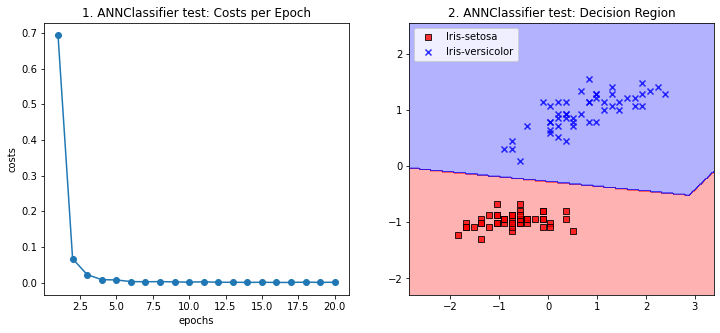

In [13]:
from projectfiles.common.encoder import one_hot_encoder

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

# 정답 레이블 생성
y = df.iloc[0:100, 4].values
ynames = {}

for idx, lbl in enumerate(np.unique(y)):
    y[y == lbl] = idx
    ynames[idx] = lbl

# 정답 레이블을 원-핫 인코딩 
y_encoded = one_hot_encoder(categorical_features='auto').fit_transform(y, drop_first=False)

# 데이터 샘플 생성 
X = df.iloc[0:100, [0, 2]].values

# 데이터 샘플 표준화
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

# 모델 학습
optimizer          = SGD(lr=0.01)
kernel_initializer = RandomNormal(mean=0., stddev=0.01, random_state=1)
bias_initializer   = Zeros()

input_size  = X_std.shape[1]
output_size = y_encoded.shape[1]
hidden_size = 5

model = ANNClassifier(input_size=input_size,    # 입력층의 크기
                      output_size=output_size,  # 출력층의 크기
                      hidden_size=hidden_size,  # 은닉층의 크기
                      activation='relu',    # 은닉층의 활성화 함수
                      loss='cee',           # 손실 함수
                      optimizer=optimizer,  # 최적화 모델
                      kernel_initializer=kernel_initializer,  # 가중치 행렬 초기화 모델
                      bias_initializer=bias_initializer,      # 편향 벡터 초기화 모델
                      random_state=1)
model.fit(X_std, y_encoded, batch_size=100, epochs=500)

# 결과 생성
result = plt.figure(figsize=(12, 5))
ax1 = result.add_subplot(1, 2, 1)
ax2 = result.add_subplot(1, 2, 2)

model.plot_costs(ax=ax1, resolution=25)
ax1.set_title('1. ANNClassifier test: Costs per Epoch')
ax1.set_xlabel('epochs')
ax1.set_ylabel('costs')

plot_decision_regions(X_std, y, model, resolution=0.02, names=ynames, ax=ax2)
ax2.set_title('2. ANNClassifier test: Decision Region')
ax2.legend(loc='upper left')

plt.show()